In [1]:
import torch
import torchvision
import time
from torch import optim, nn
from importlib import reload
import numpy as np


import GPUtil

import sys
sys.path.insert(0,'..')

#############################################
## Copy of Inceptionv3, slightly modified for recording intermeridates
#sys.path.append('/home/cshetty2/sct/pytorch')
#import reformated_models.inception_modified as inception_modified

## Modified Alexnet, with a'factor' by which it can be made 'fat' 
#import simple_model as sm

## Placer libs of baechi
#sys.path.append('/home/cshetty2/sct')
#from placer.placer_lib import *
##############################################

#import dummyModels as dm
import baechiTest_dummyModels as dm


######## For profiler (some experiments. Not required) #################
from torch.profiler import profile, record_function, ProfilerActivity



import matplotlib.pyplot as plt

######## For debug purposes ONLY ########
import ctypes, gc
import psutil, os

###############################Utilities#################################
### From https://discuss.pytorch.org/t/how-pytorch-releases-variable-garbage/7277
def memReport():
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            print(type(obj), obj.size())
    
def cpuStats():
        print(sys.version)
        print(psutil.cpu_percent())
        print(psutil.virtual_memory())  # physical memory usage
        pid = os.getpid()
        py = psutil.Process(pid)
        memoryUse = py.memory_info()[0] / 2. ** 30  # memory use in GB...I think
        print('memory GB:', memoryUse)
        
## Print memory of all available GPU's
def print_gpu_memory():
    for i in range(torch.cuda.device_count()):
        #print(torch.cuda.get_device_name(i))
        print("GPU:", i)
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(i)/1024**3,8), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(i)/1024**3,8), 'GB')
        #print("-----------------")
        #GPUtil.showUtilization()
        print("-----------")
#########################################

%matplotlib inline
%load_ext autoreload
%autoreload 2

print_gpu_memory()

GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 2
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------


In [2]:
import threading
from random import expovariate

In [3]:
from baechi_units_bigbrain import *

Experiment aims to demonstrate the advantage of packing training jobs on GPU (based on the resource requirements) rather than allotting integer number of GPUs per job (as container based approach would do)

Measure: Throughput for these two cases and compare:
- (1) one GPU allocation for each incoming jobs on FCFS basis
- (2) decide a split of the incoming model among the two GPUs and run on best effort basis (the entire model maybe placed on one GPUs)

Expectation: (2) should be more than (1) for two reasons:
- granualr GPU allocation is more efficient
- the model choosen itself runs faster when split across 2 gpus than 1 as described in next section

Primitives:

- GPUs : Setup consists of only 2 GPUs on one node
- Jobs : All incoming jobs will be of same kind - to train a model dm.parallelModelThreeLayerSplit as described below
- Training Script: run_train() is the main training routine. When a job arrives, a split for the model among two GPU's is 
- Job queue: jobs arrive as poisson process. Job queue maintains the cluster state and allots jobs with appropriate split while preventing OOMs

In [4]:
def get_model(model_name, fct, repetable): 
    if model_name == "inception_v3":
        model = inception_modified.inception_v3(pretrained=True)
        inp_size_single = (3, 299, 299)
        opt_size = 1000

    if model_name == "TallParallelModel":
        factor = fct
        inp_size_single = (1, 512*factor)
        model = dm.tallParallelModel(factor, repetable)
        opt_size = 1000


    if model_name == "ParallelTwoLayer":
        factor = fct
        inp_size_single = (1, int(512*factor))
        model = dm.parallelTwoLayer(factor, repetable)
        opt_size = 512*fct

    if model_name == "ParallelThreeLayer":
        factor = fct
        inp_size_single = (1, int(512*factor))
        model = dm.parallelThreeLayer(factor, repetable)
        opt_size = 512*fct


        
    return model, inp_size_single, opt_size
  

### Training script

In [5]:
def run_train(model, batch_size, Nrun, inp_size_single, opt_size, \
              first_gpu, final_gpu ):     

    optimizer = optim.SGD(model.parameters(), lr = 0.0001); 
    criterion = nn.MSELoss()
    dataset = torchvision.datasets.FakeData(
        size= Nrun * batch_size,
        image_size=inp_size_single,
        num_classes=opt_size,
        transform=torchvision.transforms.ToTensor())
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    result = []

    times = []
    for batch_idx, (inp, oup) in enumerate(data_loader):
        ### TODO: Remove this all-device sync by running each job in a stream
        torch.cuda.synchronize(0);torch.cuda.synchronize(1);torch.cuda.synchronize(2);torch.cuda.synchronize(3)
        labels = torch.randn((batch_size,opt_size)).to(final_gpu)
        start = time.time()
        inp = inp.to(first_gpu); 
        optimizer.zero_grad()
        output = model(inp)
        #torch.cuda.synchronize(0);torch.cuda.synchronize(1);torch.cuda.synchronize(2);torch.cuda.synchronize(3)
        ######################### loss compute ################################################
        loss = criterion(output, labels )
        ##################################################################################
        loss.backward(loss)
        optimizer.step()
        torch.cuda.synchronize(0);torch.cuda.synchronize(1);torch.cuda.synchronize(2);torch.cuda.synchronize(3)
        end = time.time()
        times.append(1000*(end-start))
    if len(times)>10:
        gpu_time = np.mean(times[10:])
    else:
        gpu_time = True
    
    #### Release memory
    del inp
    del output
    try:
        del labels
        del optimizer
        del loss
    except: pass

    return gpu_time


In [6]:
def run_job(job_id, algo, model_name, fct, batch_size, Nrun, done_flag, exit_time ): 
    
    repetable = 0
    model, inp_size_single, opt_size = get_model(model_name, fct, repetable)
    
    inp_size = (batch_size,) + inp_size_single
    out_size = (batch_size, opt_size)
    
    available_gpus = [1,2]
    args.batch_size = str(batch_size)
    
    if algo == 'baseline':
        gpu_id = job_queue[job_id]['model_split'][0]
        model = model.to(gpu_id)
        avg_gpu_time = run_train(model, batch_size, Nrun, inp_size_single, opt_size, \
                  gpu_id, gpu_id)
        del model
        gc.collect()              ## To clean any circular references
        torch.cuda.empty_cache()
        
    
    if algo == 'baechi':
        ################################################################################

        return_graph, tester = build_graph(model, args.prof_gpu_id, args.prof_rounds, inp_size = inp_size_single)
        available_device_list = {k:device_list[k] for k in available_gpus}
        DEVICE_GRAPH_MULTIPLE = create_device_graph(available_device_list)

        placed_op_graph = m_sct(return_graph, DEVICE_GRAPH_MULTIPLE)
        copy_p(return_graph, tester)

        #########################################################
        resource_usage = {gpu_id:0 for gpu_id in available_gpus}
        first_gpu = -1
        for node_id in tester.sub_module_nodes:
            node = tester.sub_module_nodes[node_id]
            curr_gpu_id    = node.p
            if first_gpu < 0:
                first_gpu = curr_gpu_id
            curr_res_usage = node.input_memory + node.persistent_memory \
                            + node.temporary_memory
            resource_usage[curr_gpu_id] += curr_res_usage
            print("layer:", node.module)
            print("gpu:", curr_gpu_id, ", resource:", curr_res_usage)
        final_gpu = curr_gpu_id
        print("Net Resource:")
        print([resource_usage[gpu_id]/device_list[gpu_id]['memory_size'] for gpu_id in available_gpus])
        print('-'*30)
        
        ######################################################

        Assign(tester)

        avg_gpu_time = run_train(tester.model, batch_size, Nrun, inp_size_single, opt_size, \
                  first_gpu, final_gpu )
        ################################################################################
        del tester
        del placed_op_graph
        del return_graph
        gc.collect()              ## To clean any circular references
        torch.cuda.empty_cache() ## Empty cache used by Pytorch (does so across all threads)

    done_flag[0] = avg_gpu_time
    exit_time[0] = time.time()
    print_gpu_memory()
    print("Mean time taken:", avg_gpu_time)

    return 0
    

In [7]:
print_gpu_memory()

GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 2
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------


In [8]:
####################### GLOBALS #####################################3

### dict of (gpu_id, fraction of gpu available)
resource_manager   = {}  
resource_manager[1]= 1
resource_manager[2]= 1

### dict of job_id -> dict{model_split, status_flag, arrival_time, entry_time, exit_time}
job_queue          = {}  

end_exp_flag = [0] #flag to indicate end of experiment

In [9]:
def get_split_algo_1():
    if resource_manager[1] == 1:
        return [1,1]
    elif resource_manager[2] == 1:
        return [2,2]
    else:
        return None   

In [10]:
def get_split_algo_2():
    if resource_manager[1] > 0.5:
        return [1,1]
    elif resource_manager[2] > 0.5:
        return [2,2]
    elif (resource_manager[1] > 0.2 and resource_manager[2] > 0.2):
        return [1,2]
    return None

In [11]:
def update_resource(split, update_type):
    if update_type == "release":
        change =  1.0
    elif update_type == "acquire":
        change = -1.0
     
    if split == [1,1]:
        resource_manager[1] = resource_manager[1] + 0.7*change
    elif split == [2,2]:
        resource_manager[2] = resource_manager[2] + 0.7*change
    elif split == [1,2]:
        resource_manager[1] = resource_manager[1] + 0.3*change
        resource_manager[2] = resource_manager[2] + 0.3*change
    else:
        print("Error! split is invalid")
    

In [12]:
def job_arrivals(rate, T_exp):
    exp_start_time  = time.time()
    t = exp_start_time 
    job_id = 0
    
    while t < exp_start_time + T_exp:
        time.sleep(expovariate(rate))
        job_id = job_id+1
        job_queue[job_id] = {'model_split':None, 'status_flag':[0], \
                             'arrival_time':[time.time()], 'entry_time':[0], 'exit_time':[0]}
        t = time.time()
        
    end_exp_flag[0] = 1
    return 0

In [13]:
############### MAIN #########################

T_exp      = 60        # (in sec) Time for which the exp will run
rate       = 0.7         # job arrival rate
Nrun       = 30      
batch_size = 32
fct        = 6

job_server = threading.Thread(target=job_arrivals, args=(rate, T_exp, ))
job_server.start()

job_served     = 0
jobs_in_process = []
jobs_completed = [] 
no_jobs_waiting = []

t = time.time()
while not end_exp_flag[0]:
    try: 
        ## Check if a new job arrived. Will fail if no new job
        new_job = job_queue[job_served+1] 
        
        #print(job_served+1)
        #print(job_queue)
        
        if (new_job['entry_time'][0]):
            print("Something went wrong! New job already has entry time")
        
        ## get a resource allocation for new job
        
        #split = get_split_algo_1()
        #algo = 'baseline'
        
        split = get_split_algo_2()
        algo = 'baechi'
        
        model_name = "ParallelThreeLayer"
        
        
        ## If resource is available then a split is returned 
        ## Else just wait
        if split:   
            new_job['model_split'] = split
            ### Update resources
            update_resource(split, 'acquire')
            if resource_manager[1]<0 or resource_manager[2]<0:
                print("Error! There's nothing like negative resources!")
            
            ### Spawn a thread to start the new job
            new_job['entry_time'][0]  = time.time()

            job_submit = threading.Thread(target=run_job, args=(job_served+1, algo, model_name, fct, \
                                                                  batch_size, Nrun, new_job['status_flag'], \
                                                                  new_job['exit_time'], ))
            job_submit.start()
            job_served = job_served+1
            jobs_in_process.append(job_served)
            
        else:
            pass
        
        
    except:
        pass
    
    completed = []
    for inprocess_job_id in jobs_in_process:
        if job_queue[inprocess_job_id]['status_flag'][0]:
            completed.append(inprocess_job_id)   
            ## Release resources
            update_resource(job_queue[inprocess_job_id]['model_split'], 'release')
    
    jobs_completed = jobs_completed +  completed 
    for i in completed:
        jobs_in_process.remove(i)
        
    t_now = time.time()
    if t_now-t>1:
        ## Check for completed jobs 
        no_waiting = len(job_queue)-job_served
        no_jobs_waiting.append(no_waiting)
        print('*'*20)
        print("Jobs in process:", len(jobs_in_process))
        print("Jobs waiting:",no_waiting )
        print("Jobs Completed: ", len(jobs_completed))
        print('*'*20)
        t = t_now
        

    time.sleep(0.1)
    

********************
Jobs in process: 0
Jobs waiting: 0
Jobs Completed:  0
********************
********************
Jobs in process: 3
Jobs waiting: 0
Jobs Completed:  0
********************
********************
Jobs in process: 3
Jobs waiting: 0
Jobs Completed:  0
********************
Profiling started ********************
********************
Jobs in process: 3
Jobs waiting: 2
Jobs Completed:  0
********************
Profiling startedProfiling started ********************
 ********************
--> Module name:  _squeezeLayer()
--> Module name:  Linear(in_features=3072, out_features=12288, bias=True)


/home/cshetty2/anaconda3/envs/baechi/lib/python3.6/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/cshetty2/anaconda3/envs/baechi/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32, 32])) that is different to the input size (torch.Size([32, 3072])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--> Module name:  Linear(in_features=12288, out_features=3072, bias=True)
--> Module name:  Linear(in_features=3072, out_features=3072, bias=True)
--> Module name:  Linear(in_features=12288, out_features=3072, bias=True)
--> Module name:  Linear(in_features=3072, out_features=3072, bias=True)
--> Module name:  Linear(in_features=12288, out_features=3072, bias=True)
--> Module name:  Linear(in_features=3072, out_features=3072, bias=True)
--> Module name:  _concatenateLayer()
--> Module name:  Linear(in_features=9216, out_features=3072, bias=True)
--> Module name:  Linear(in_features=3072, out_features=3072, bias=True)
--> Module name:  _squeezeLayer()
--> Module name:  Linear(in_features=3072, out_features=12288, bias=True)
--> Module name:  Linear(in_features=12288, out_features=3072, bias=True)
--> Module name:  Linear(in_features=3072, out_features=3072, bias=True)
--> Module name:  Linear(in_features=12288, out_features=3072, bias=True)
--> Module name:  Linear(in_features=3072, out

/home/cshetty2/anaconda3/envs/baechi/lib/python3.6/site-packages/torch/cuda/memory.py:263: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


********************
Jobs in process: 3
Jobs waiting: 2
Jobs Completed:  0
********************
********************
Jobs in process: 3
Jobs waiting: 2
Jobs Completed:  0
********************
********************
Jobs in process: 3
Jobs waiting: 2
Jobs Completed:  0
********************


2021-11-11 16:57:51,011 - m_sct_v1:157 - INFO - Start LP solver.


make_dot started ********************
Dealing with this variable: <AddmmBackward object at 0x7f3702bc6550>
Dealing with this variable: <AddmmBackward object at 0x7f3702bc64e0>
Dealing with this variable: <CatBackward object at 0x7f3702b47438>
Dealing with this variable: <AddmmBackward object at 0x7f3702b47668>
Dealing with this variable: <AddmmBackward object at 0x7f3702b4c898>
Dealing with this variable: <AddmmBackward object at 0x7f3702b4c320>
Dealing with this variable: <SqueezeBackward0 object at 0x7f3702b4c0b8>
Dealing with this variable: <TBackward object at 0x7f3702b4c860>
Dealing with this variable: <TBackward object at 0x7f3702b4cc88>
Dealing with this variable: <TBackward object at 0x7f3702b4c710>
Dealing with this variable: <AddmmBackward object at 0x7f3702b4c978>
Dealing with this variable: <AddmmBackward object at 0x7f3702b4cc50>
Dealing with this variable: <AddmmBackward object at 0x7f3702b4c320>
Dealing with this variable: <TBackward object at 0x7f3702b4c588>
Dealing wit

2021-11-11 16:57:51,180 - m_sct_v1:162 - INFO - LP solver finished. Relaxed makespan soultion: 5.280446
2021-11-11 16:57:51,181 - m_sct_v1:140 - INFO - Favorite child round threshold: 0.5
2021-11-11 16:57:51,185 - m_sct:143 - INFO - # favorite child: 7
2021-11-11 16:57:51,187 - m_sct:144 - INFO - # favorite child changes: 0


Available mem:  8000000000
Op memory: 393216.0
Available mem:  8000000000
Op memory: 393216.0
1
Available mem:  8000000000
Op memory: 393216.0
Checking placement***************************************
Available mem:  8000000000
Op memory: 393216.0
True
Available mem:  8000000000
Op memory: 393216.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  8000000000
_squeezeLayer()  :  0
Available mem:  7999606784.0
Op memory: 153010176.0
Available mem:  8000000000
Op memory: 153010176.0
Available mem:  7999606784.0
Op memory: 153010176.0
1
Available mem:  7999606784.0
Op memory: 153010176.0
Checking placement***************************************
Available mem:  7999606784.0
Op memory: 153010176.0
True
Available mem:  7999606784.0
Op memory: 153010176.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  7999606784.0
Linear(in_features=3072, out_features=12288, bias=True)  :  151044096
Available mem:  7847383040.0
Op memory: 151400448.0

2021-11-11 16:57:51,249 - m_sct:172 - INFO - SCT estimated runtime: 0.000006


Op memory: 151400448.0
Available mem:  7658221568.0
Op memory: 151400448.0
Available mem:  8000000000
Op memory: 151400448.0
Available mem:  7658221568.0
Op memory: 151400448.0
Available mem:  8000000000
Op memory: 151400448.0
Available mem:  7658221568.0
Op memory: 151400448.0
Available mem:  8000000000
Op memory: 151400448.0
2
Available mem:  8000000000
Op memory: 151400448.0
Checking placement***************************************
Available mem:  8000000000
Op memory: 151400448.0
True
Available mem:  8000000000
Op memory: 151400448.0
********************
Device id:  2
Memory limit:  8000000000
Availale memory:  8000000000
Linear(in_features=12288, out_features=3072, bias=True)  :  151007232
Available mem:  7658221568.0
Op memory: 151400448.0
Available mem:  7848599552.0
Op memory: 151400448.0
Available mem:  7658221568.0
Op memory: 151400448.0
Available mem:  7848599552.0
Op memory: 151400448.0
1
Available mem:  7658221568.0
Op memory: 151400448.0
Checking placement****************

2021-11-11 16:57:51,840 - m_sct_v1:157 - INFO - Start LP solver.


make_dot started ********************
Dealing with this variable: <AddmmBackward object at 0x7f3700049cf8>
Dealing with this variable: <AddmmBackward object at 0x7f3700099a20>
Dealing with this variable: <CatBackward object at 0x7f3702b47630>
Dealing with this variable: <AddmmBackward object at 0x7f3702b474e0>
Dealing with this variable: <AddmmBackward object at 0x7f37180518d0>
Dealing with this variable: <AddmmBackward object at 0x7f36f8a58128>
Dealing with this variable: <SqueezeBackward0 object at 0x7f36f8a58828>
Dealing with this variable: <TBackward object at 0x7f36f8a58550>
Dealing with this variable: <TBackward object at 0x7f36f8a58240>
Dealing with this variable: <TBackward object at 0x7f3718051898>
Dealing with this variable: <AddmmBackward object at 0x7f378241eac8>
Dealing with this variable: <AddmmBackward object at 0x7f3718051860>
Dealing with this variable: <AddmmBackward object at 0x7f36f8a58128>
Dealing with this variable: <TBackward object at 0x7f36f8a58278>
Dealing wit

2021-11-11 16:57:51,872 - m_sct_v1:157 - INFO - Start LP solver.


Dealing with this variable: <AddmmBackward object at 0x7f3702bc6cc0>
Dealing with this variable: <CatBackward object at 0x7f3702bc6cf8>
Dealing with this variable: <AddmmBackward object at 0x7f3700049f98>
Dealing with this variable: <AddmmBackward object at 0x7f36f8a58e10>
Dealing with this variable: <AddmmBackward object at 0x7f36f8a585f8>
Dealing with this variable: <SqueezeBackward0 object at 0x7f36f8a58c18>
Dealing with this variable: <TBackward object at 0x7f36f8a58fd0>
Dealing with this variable: <TBackward object at 0x7f36f8a58d30>
Dealing with this variable: <TBackward object at 0x7f36f8a587b8>
Dealing with this variable: <AddmmBackward object at 0x7f3700049e80>
Dealing with this variable: <AddmmBackward object at 0x7f36f8a58cc0>
Dealing with this variable: <AddmmBackward object at 0x7f36f8a585f8>
Dealing with this variable: <TBackward object at 0x7f36f8a58668>
Dealing with this variable: <TBackward object at 0x7f36f8a58a58>
Dealing with this variable: <AddmmBackward object at 

2021-11-11 16:57:51,978 - m_sct_v1:162 - INFO - LP solver finished. Relaxed makespan soultion: 5.646901


  Primal.  obj: 6.6275956145e+00    nrm: 7e+00    Viol.  con: 2e-09    var: 0e+00  


2021-11-11 16:57:51,979 - m_sct_v1:140 - INFO - Favorite child round threshold: 0.5


  Dual.    obj: 6.6275956189e+00    nrm: 1e+00    Viol.  con: 3e-09    var: 3e-09  


2021-11-11 16:57:51,980 - m_sct:143 - INFO - # favorite child: 7


2021-11-11 16:57:51,982 - m_sct:144 - INFO - # favorite child changes: 0


Available mem: Basic solution summary
 8000000000
Op memory: 393216.0
Available mem:  8000000000
Op memory: 393216.0
1
Available mem:  8000000000
Op memory: 393216.0
Checking placement***************************************
Available mem:  8000000000
Op memory: 393216.0
True
Available mem:  8000000000
Op memory: 393216.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  8000000000
_squeezeLayer()  :  0
Available mem:   Problem status  : PRIMAL_AND_DUAL_FEASIBLE
 7999606784.0
Op memory: 152616960.0
Available mem:  8000000000
Op memory: 152616960.0
Available mem:  7999606784.0
Op memory: 152616960.0
1
Available mem:  7999606784.0
Op memory: 152616960.0
Checking placement***************************************
Available mem:  7999606784.0
Op memory: 152616960.0
True
Available mem:  7999606784.0
Op memory: 152616960.0
********************
Device id:  1  Solution status : OPTIMAL

Memory limit:  8000000000
Availale memory:  7999606784.0
Linear(in_features=3072, 

2021-11-11 16:57:52,009 - m_sct_v1:162 - INFO - LP solver finished. Relaxed makespan soultion: 6.627596
2021-11-11 16:57:52,013 - m_sct_v1:140 - INFO - Favorite child round threshold: 0.5
2021-11-11 16:57:52,018 - m_sct:143 - INFO - # favorite child: 7
2021-11-11 16:57:52,023 - m_sct:144 - INFO - # favorite child changes: 0


151400448.0
Available mem:  8000000000
Op memory: 151400448.0
Available mem:  7658221568.0
Op memory: 151400448.0
Available mem:  8000000000
Op memory: 151400448.0
Available mem:  7658221568.0
Op memory: 151400448.0
Available mem:  8000000000
Op memory: 151400448.0
Available mem:  7658221568.0
Op memory: 151400448.0
Available mem:  8000000000
Op memory: 151400448.0
2
Available mem:  8000000000
Op memory: 151400448.0
Checking placement***************************************
Available mem:  8000000000
Op memory: 151400448.0
True
Available mem:  8000000000
Op memory: 151400448.0
********************
Device id:  2
Memory limit:  8000000000
Availale memory:  8000000000
Linear(in_features=12288, out_features=3072, bias=True)  :  151007232
Available mem:  7658221568.0
Op memory: 151400448.0
Available mem:  7848599552.0
Op memory: 151400448.0
Available mem:  7658221568.0
Op memory: 151400448.0
Available mem:  7848599552.0
Op memory: 151400448.0
1
Available mem:  7658221568.0
Op memory: 1514004

2021-11-11 16:57:52,049 - m_sct:172 - INFO - SCT estimated runtime: 0.000006


********************
Device id:  1
Memory limit:  8000000000
Availale memory:  7847383040.0
Linear(in_features=12288, out_features=3072, bias=True)  :  151007232
Available mem:  7695982592.0
Op memory: 151400448.0
Available mem:  8000000000
Op memory: 151400448.0
Available mem:  7695982592.0
Op memory: 151400448.0
Available mem:  8000000000
Op memory: 151400448.0
Available mem:  7695982592.0
Op memory: 151400448.0
Available mem:  8000000000
Op memory: 151400448.0
Available mem:  7695982592.0
Op memory: 151400448.0
Available mem:  8000000000
Op memory: 151400448.0
Available mem:  7695982592.0
Op memory: 38154240.0
Available mem:  8000000000
Op memory: 38154240.0
Available mem:  7695982592.0
Op memory: 151400448.0
Available mem:  7695982592.0
Op memory: 151400448.0
Available mem:  7695982592.0
Op memory: 38154240.0
1
Available mem:  7695982592.0
Op memory: 38154240.0
Checking placement***************************************
Available mem:  7695982592.0
Op memory: 38154240.0
True
Availabl

2021-11-11 16:57:52,064 - m_sct:172 - INFO - SCT estimated runtime: 0.000007


layer: _squeezeLayer()
gpu: 1 , resource: 393216.0
layer: Linear(in_features=3072, out_features=12288, bias=True)
gpu: 1 , resource: 151437312.0
layer: Linear(in_features=12288, out_features=3072, bias=True)
gpu: 2 , resource: 152580096.0
layer: Linear(in_features=3072, out_features=3072, bias=True)
gpu: 2 , resource: 38154240.0
layer: Linear(in_features=12288, out_features=3072, bias=True)
gpu: 1 , resource: 152580096.0
layer: Linear(in_features=3072, out_features=3072, bias=True)
gpu: 1 , resource: 38154240.0
layer: Linear(in_features=12288, out_features=3072, bias=True)
gpu: 1 , resource: 152580096.0
layer: Linear(in_features=3072, out_features=3072, bias=True)
gpu: 1 , resource: 38154240.0
layer: _concatenateLayer()
gpu: 1 , resource: 1179648.0
layer: Linear(in_features=9216, out_features=3072, bias=True)
gpu: 1 , resource: 114438144.0
layer: Linear(in_features=3072, out_features=3072, bias=True)
gpu: 1 , resource: 38154240.0
Net Resource:
[0.085883904, 0.023841792]
---------------

********************
Jobs in process: 3
Jobs waiting: 3
Jobs Completed:  3
********************
********************
Jobs in process: 3
Jobs waiting: 3
Jobs Completed:  3
********************
********************
Jobs in process: 3
Jobs waiting: 5
Jobs Completed:  3
********************
********************
Jobs in process: 3
Jobs waiting: 5
Jobs Completed:  3
********************


2021-11-11 16:58:03,456 - m_sct_v1:157 - INFO - Start LP solver.


make_dot started ********************
Dealing with this variable: <AddmmBackward object at 0x7f3700049be0>
Dealing with this variable: <AddmmBackward object at 0x7f3700064e48>
Dealing with this variable: <CatBackward object at 0x7f3700064a58>
Dealing with this variable: <AddmmBackward object at 0x7f3700064320>
Dealing with this variable: <AddmmBackward object at 0x7f3700064358>
Dealing with this variable: <AddmmBackward object at 0x7f3700064668>
Dealing with this variable: <SqueezeBackward0 object at 0x7f3700049080>
Dealing with this variable: <TBackward object at 0x7f3700049518>
Dealing with this variable: <TBackward object at 0x7f3700064438>
Dealing with this variable: <TBackward object at 0x7f3700064a90>
Dealing with this variable: <AddmmBackward object at 0x7f3700064390>
Dealing with this variable: <AddmmBackward object at 0x7f3700049c88>
Dealing with this variable: <AddmmBackward object at 0x7f3700064668>
Dealing with this variable: <TBackward object at 0x7f3700064b38>
Dealing wit

2021-11-11 16:58:03,609 - m_sct_v1:162 - INFO - LP solver finished. Relaxed makespan soultion: 5.505370
2021-11-11 16:58:03,611 - m_sct_v1:140 - INFO - Favorite child round threshold: 0.5
2021-11-11 16:58:03,612 - m_sct:143 - INFO - # favorite child: 7
2021-11-11 16:58:03,613 - m_sct:144 - INFO - # favorite child changes: 0


Available mem:  8000000000
Op memory: 393216.0
Available mem:  8000000000
Op memory: 393216.0
1
Available mem:  8000000000
Op memory: 393216.0
Checking placement***************************************
Available mem:  8000000000
Op memory: 393216.0
True
Available mem:  8000000000
Op memory: 393216.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  8000000000
_squeezeLayer()  :  0
Available mem:  7999606784.0
Op memory: 152616960.0
Available mem:  8000000000
Op memory: 152616960.0
Available mem:  7999606784.0
Op memory: 152616960.0
1
Available mem:  7999606784.0
Op memory: 152616960.0
Checking placement***************************************
Available mem:  7999606784.0
Op memory: 152616960.0
True
Available mem:  7999606784.0
Op memory: 152616960.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  7999606784.0
Linear(in_features=3072, out_features=12288, bias=True)  :  151044096
Available mem:  7847383040.0
Op memory: 151400448.0

2021-11-11 16:58:03,681 - m_sct_v1:157 - INFO - Start LP solver.
2021-11-11 16:58:03,683 - m_sct:172 - INFO - SCT estimated runtime: 0.000006


Available mem:  7357767680.0
Op memory: 38154240.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  7357767680.0
Linear(in_features=3072, out_features=3072, bias=True)  :  37761024
layer: _squeezeLayer()
gpu: 1 , resource: 393216.0
layer: Linear(in_features=3072, out_features=12288, bias=True)
gpu: 1 , resource: 151437312.0
layer: Linear(in_features=12288, out_features=3072, bias=True)
gpu: 1 , resource: 152580096.0
layer: Linear(in_features=3072, out_features=3072, bias=True)
gpu: 1 , resource: 38154240.0
layer: Linear(in_features=12288, out_features=3072, bias=True)
gpu: 1 , resource: 152580096.0
layer: Linear(in_features=3072, out_features=3072, bias=True)
gpu: 1 , resource: 38154240.0
layer: Linear(in_features=12288, out_features=3072, bias=True)
gpu: 2 , resource: 152580096.0
layer: Linear(in_features=3072, out_features=3072, bias=True)
gpu: 2 , resource: 38154240.0
layer: _concatenateLayer()
gpu: 1 , resource: 1179648.0
layer: Linear(in_features=9216

2021-11-11 16:58:03,769 - m_sct_v1:162 - INFO - LP solver finished. Relaxed makespan soultion: 5.678888
2021-11-11 16:58:03,770 - m_sct_v1:140 - INFO - Favorite child round threshold: 0.5
2021-11-11 16:58:03,770 - m_sct:143 - INFO - # favorite child: 7
2021-11-11 16:58:03,771 - m_sct:144 - INFO - # favorite child changes: 0


Available mem:  8000000000
Op memory: 77082624.0
Available mem:  8000000000
Op memory: 77082624.0
1
Available mem:  8000000000
Op memory: 77082624.0
Checking placement***************************************
Available mem:  8000000000
Op memory: 77082624.0
True
Available mem:  8000000000
Op memory: 77082624.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  8000000000
_squeezeLayer()  :  0
Available mem:  7999606784.0
Op memory: 152616960.0
Available mem:  8000000000
Op memory: 152616960.0
Available mem:  7999606784.0
Op memory: 152616960.0
1
Available mem:  7999606784.0
Op memory: 152616960.0
Checking placement***************************************
Available mem:  7999606784.0
Op memory: 152616960.0
True
Available mem:  7999606784.0
Op memory: 152616960.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  7999606784.0
Linear(in_features=3072, out_features=12288, bias=True)  :  151044096
Available mem:  7847383040.0
Op memory: 1

2021-11-11 16:58:03,795 - m_sct:172 - INFO - SCT estimated runtime: 0.000006


 7470239744.0
Op memory: 113651712.0
Available mem:  7811231744.0
Op memory: 113651712.0
Available mem:  7470239744.0
Op memory: 113651712.0
1
Available mem:  7470239744.0
Op memory: 113651712.0
Checking placement***************************************
Available mem:  7470239744.0
Op memory: 113651712.0
True
Available mem:  7470239744.0
Op memory: 113651712.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  7470239744.0
Linear(in_features=9216, out_features=3072, bias=True)  :  113258496
Available mem:  7357767680.0
Op memory: 38154240.0
Available mem:  7811231744.0
Op memory: 38154240.0
Available mem:  7357767680.0
Op memory: 38154240.0
1
Available mem:  7357767680.0
Op memory: 38154240.0
Checking placement***************************************
Available mem:  7357767680.0
Op memory: 38154240.0
True
Available mem:  7357767680.0
Op memory: 38154240.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  7357767680.0
Linear(in_feat

2021-11-11 16:58:04,396 - m_sct_v1:157 - INFO - Start LP solver.


Module:               Linear(in_features=3072, out_features=3072, bias=True)
GPU:                  1
Memory change:        76308480
Layer size:           37761024
Net memory occupied:  4078387200
**************************************************
make_dot started ********************
Dealing with this variable: <AddmmBackward object at 0x7f3700099898>
Dealing with this variable: <AddmmBackward object at 0x7f3700099748>
Dealing with this variable: <CatBackward object at 0x7f3700049518>
Dealing with this variable: <AddmmBackward object at 0x7f3700064b70>
Dealing with this variable: <AddmmBackward object at 0x7f370003d470>
Dealing with this variable: <AddmmBackward object at 0x7f370003d908>
Dealing with this variable: <SqueezeBackward0 object at 0x7f370003d0b8>
Dealing with this variable: <TBackward object at 0x7f370003d6d8>
Dealing with this variable: <TBackward object at 0x7f370003d390>
Dealing with this variable: <TBackward object at 0x7f370003d978>
Dealing with this variable: <AddmmBa

2021-11-11 16:58:04,510 - m_sct_v1:162 - INFO - LP solver finished. Relaxed makespan soultion: 6.874738
2021-11-11 16:58:04,512 - m_sct_v1:140 - INFO - Favorite child round threshold: 0.5
2021-11-11 16:58:04,513 - m_sct:143 - INFO - # favorite child: 7
2021-11-11 16:58:04,514 - m_sct:144 - INFO - # favorite child changes: 0


Available mem:  8000000000
Op memory: 393216.0
Available mem:  8000000000
Op memory: 393216.0
1
Available mem:  8000000000
Op memory: 393216.0
Checking placement***************************************
Available mem:  8000000000
Op memory: 393216.0
True
Available mem:  8000000000
Op memory: 393216.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  8000000000
_squeezeLayer()  :  0
Available mem:  7999606784.0
Op memory: 152616960.0
Available mem:  8000000000
Op memory: 152616960.0
Available mem:  7999606784.0
Op memory: 152616960.0
1
Available mem:  7999606784.0
Op memory: 152616960.0
Checking placement***************************************
Available mem:  7999606784.0
Op memory: 152616960.0
True
Available mem:  7999606784.0
Op memory: 152616960.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  7999606784.0
Linear(in_features=3072, out_features=12288, bias=True)  :  151044096
Available mem:  7847383040.0
Op memory: 151400448.0

2021-11-11 16:58:04,545 - m_sct:172 - INFO - SCT estimated runtime: 0.000008



True
Available mem:  8000000000
Op memory: 151400448.0
********************
Device id:  2
Memory limit:  8000000000
Availale memory:  8000000000
Linear(in_features=12288, out_features=3072, bias=True)  :  151007232
Available mem:  7658221568.0
Op memory: 151400448.0
Available mem:  7848599552.0
Op memory: 151400448.0
Available mem:  7658221568.0
Op memory: 151400448.0
Available mem:  7848599552.0
Op memory: 151400448.0
1
Available mem:  7658221568.0
Op memory: 151400448.0
Checking placement***************************************
Available mem:  7658221568.0
Op memory: 151400448.0
True
Available mem:  7658221568.0
Op memory: 151400448.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  7658221568.0
Linear(in_features=12288, out_features=3072, bias=True)  :  151007232
Available mem:  7508393984.0
Op memory: 38154240.0
Available mem:  7848599552.0
Op memory: 38154240.0
Available mem:  7848599552.0
Op memory: 38154240.0
2
Available mem:  7848599552.0
Op memory

********************
Jobs in process: 3
Jobs waiting: 8
Jobs Completed:  6
********************
Profiling started ********************
********************
Jobs in process: 3
Jobs waiting: 9
Jobs Completed:  6
********************
--> Module name:  _squeezeLayer()
--> Module name:  Linear(in_features=3072, out_features=12288, bias=True)
--> Module name:  Linear(in_features=12288, out_features=3072, bias=True)
--> Module name:  Linear(in_features=3072, out_features=3072, bias=True)
--> Module name:  Linear(in_features=12288, out_features=3072, bias=True)
--> Module name:  Linear(in_features=3072, out_features=3072, bias=True)
--> Module name:  Linear(in_features=12288, out_features=3072, bias=True)
--> Module name:  Linear(in_features=3072, out_features=3072, bias=True)
--> Module name:  _concatenateLayer()
--> Module name:  Linear(in_features=9216, out_features=3072, bias=True)
--> Module name:  Linear(in_features=3072, out_features=3072, bias=True)
********************
Jobs in process

2021-11-11 16:58:15,579 - m_sct_v1:157 - INFO - Start LP solver.


********************
Jobs in process: 3
Jobs waiting: 12
Jobs Completed:  6
********************
make_dot started ********************
Dealing with this variable: <AddmmBackward object at 0x7f3702b47400>
Dealing with this variable: <AddmmBackward object at 0x7f3702b47eb8>
Dealing with this variable: <CatBackward object at 0x7f3702b478d0>
Dealing with this variable: <AddmmBackward object at 0x7f3700049ef0>
Dealing with this variable: <AddmmBackward object at 0x7f3700099d30>
Dealing with this variable: <AddmmBackward object at 0x7f37000996d8>
Dealing with this variable: <SqueezeBackward0 object at 0x7f37000996a0>
Dealing with this variable: <TBackward object at 0x7f3700099ac8>
Dealing with this variable: <TBackward object at 0x7f3700099f98>
Dealing with this variable: <TBackward object at 0x7f3700099eb8>
Dealing with this variable: <AddmmBackward object at 0x7f3700099ba8>
Dealing with this variable: <AddmmBackward object at 0x7f3700099b00>
Dealing with this variable: <AddmmBackward objec

2021-11-11 16:58:15,726 - m_sct_v1:162 - INFO - LP solver finished. Relaxed makespan soultion: 5.908681
2021-11-11 16:58:15,728 - m_sct_v1:140 - INFO - Favorite child round threshold: 0.5
2021-11-11 16:58:15,730 - m_sct:143 - INFO - # favorite child: 7
2021-11-11 16:58:15,732 - m_sct:144 - INFO - # favorite child changes: 0
2021-11-11 16:58:15,773 - m_sct:172 - INFO - SCT estimated runtime: 0.000007


Available mem:  8000000000
Op memory: 393216.0
Available mem:  8000000000
Op memory: 393216.0
1
Available mem:  8000000000
Op memory: 393216.0
Checking placement***************************************
Available mem:  8000000000
Op memory: 393216.0
True
Available mem:  8000000000
Op memory: 393216.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  8000000000
_squeezeLayer()  :  0
Available mem:  7999606784.0
Op memory: 265875456.0
Available mem:  8000000000
Op memory: 265875456.0
Available mem:  7999606784.0
Op memory: 265875456.0
1
Available mem:  7999606784.0
Op memory: 265875456.0
Checking placement***************************************
Available mem:  7999606784.0
Op memory: 265875456.0
True
Available mem:  7999606784.0
Op memory: 265875456.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  7999606784.0
Linear(in_features=3072, out_features=12288, bias=True)  :  151044096
Available mem:  7847383040.0
Op memory: 151400448.0

2021-11-11 16:58:15,804 - m_sct_v1:157 - INFO - Start LP solver.


make_dot started ********************
Dealing with this variable: <AddmmBackward object at 0x7f3702bc6748>
Dealing with this variable: <AddmmBackward object at 0x7f3702bc67f0>
Dealing with this variable: <CatBackward object at 0x7f3702bc6160>
Dealing with this variable: <AddmmBackward object at 0x7f3700099c18>
Dealing with this variable: <AddmmBackward object at 0x7f3700099be0>
Dealing with this variable: <AddmmBackward object at 0x7f3700099f98>
Dealing with this variable: <SqueezeBackward0 object at 0x7f3700099eb8>
Dealing with this variable: <TBackward object at 0x7f37000996a0>
Dealing with this variable: <TBackward object at 0x7f3700099b00>
Dealing with this variable: <TBackward object at 0x7f3700099ba8>
Dealing with this variable: <AddmmBackward object at 0x7f3700099710>
Dealing with this variable: <AddmmBackward object at 0x7f3700099da0>
Dealing with this variable: <AddmmBackward object at 0x7f3700099f98>
Dealing with this variable: <TBackward object at 0x7f3700099f28>
Dealing wit

2021-11-11 16:58:15,879 - m_sct_v1:162 - INFO - LP solver finished. Relaxed makespan soultion: 6.180749
2021-11-11 16:58:15,880 - m_sct_v1:140 - INFO - Favorite child round threshold: 0.5
2021-11-11 16:58:15,881 - m_sct:143 - INFO - # favorite child: 7
2021-11-11 16:58:15,881 - m_sct:144 - INFO - # favorite child changes: 0


Available mem:  8000000000
Op memory: 393216.0
Available mem:  8000000000
Op memory: 393216.0
1
Available mem:  8000000000
Op memory: 393216.0
Checking placement***************************************
Available mem:  8000000000
Op memory: 393216.0
True
Available mem:  8000000000
Op memory: 393216.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  8000000000
_squeezeLayer()  :  0
Available mem:  7999606784.0
Op memory: 152616960.0
Available mem:  8000000000
Op memory: 152616960.0
Available mem:  7999606784.0
Op memory: 152616960.0
1
Available mem:  7999606784.0
Op memory: 152616960.0
Checking placement***************************************
Available mem:  7999606784.0
Op memory: 152616960.0
True
Available mem:  7999606784.0
Op memory: 152616960.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  7999606784.0
Linear(in_features=3072, out_features=12288, bias=True)  :  151044096
Available mem:  7847383040.0
Op memory: 151400448.0

2021-11-11 16:58:15,908 - m_sct:172 - INFO - SCT estimated runtime: 0.000007


GPU:                  2
Memory change:        75522048
 7470239744.0
Op memory: 114044928.0
Available mem:  7811231744.0
Op memory: 114044928.0
Available mem:  7470239744.0
Op memory: 114044928.0
1
Available mem:  7470239744.0
Op memory: 114044928.0
Checking placement***************************************
Available mem:  7470239744.0
Op memory: 114044928.0
True
Available mem:  7470239744.0
Op memory: 114044928.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  7470239744.0
Linear(in_features=9216, out_features=3072, bias=True)  :  113258496
Available mem:  7357767680.0
Op memory: 38166528.0
Available mem:  7811231744.0
Op memory: 38166528.0
Available mem:  7357767680.0
Op memory: 38166528.0
1
Available mem:  7357767680.0
Op memory: 38166528.0
Checking placement***************************************
Available mem:  7357767680.0
Op memory: 38166528.0
True
Available mem:  7357767680.0
Op memory: 38166528.0
********************
Device id:  1
Memory limit:  8

2021-11-11 16:58:16,367 - m_sct_v1:157 - INFO - Start LP solver.


Module:               Linear(in_features=12288, out_features=3072, bias=True)
GPU:                  1
Memory change:        302800896
Layer size:           151007232
Net memory occupied:  3700826112
**************************************************
Module:               Linear(in_features=3072, out_features=3072, bias=True)
GPU:                  1
Memory change:        75522048
Layer size:           37761024
Net memory occupied:  3776348160
**************************************************
Module:               _concatenateLayer()
GPU:                  1
Memory change:        0
Layer size:           0
Net memory occupied:  3776348160
**************************************************
make_dot started ********************
Dealing with this variable: <AddmmBackward object at 0x7f3718051898>
Dealing with this variable: <AddmmBackward object at 0x7f37180511d0>
Dealing with this variable: <CatBackward object at 0x7f3718051128>
Dealing with this variable: <AddmmBackward object at 0x7f3702b

2021-11-11 16:58:16,555 - m_sct_v1:162 - INFO - LP solver finished. Relaxed makespan soultion: 7.080684
2021-11-11 16:58:16,558 - m_sct_v1:140 - INFO - Favorite child round threshold: 0.5
2021-11-11 16:58:16,560 - m_sct:143 - INFO - # favorite child: 8
2021-11-11 16:58:16,562 - m_sct:144 - INFO - # favorite child changes: 0


Available mem:  8000000000
Op memory: 393216.0
Available mem:  8000000000
Op memory: 393216.0
1
Available mem:  8000000000
Op memory: 393216.0
Checking placement***************************************
Available mem:  8000000000
Op memory: 393216.0
True
Available mem:  8000000000
Op memory: 393216.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  8000000000
_squeezeLayer()  :  0
Available mem:  7999606784.0
Op memory: 152616960.0
Available mem:  8000000000
Op memory: 152616960.0
Available mem:  7999606784.0
Op memory: 152616960.0
1
Available mem:  7999606784.0
Op memory: 152616960.0
Checking placement***************************************
Available mem:  7999606784.0
Op memory: 152616960.0
True
Available mem:  7999606784.0
Op memory: 152616960.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  7999606784.0
Linear(in_features=3072, out_features=12288, bias=True)  :  151044096
Available mem:  7847383040.0
Op memory: 151400448.0

2021-11-11 16:58:16,596 - m_sct:172 - INFO - SCT estimated runtime: 0.000008


Op memory: 151400448.0
Checking placement***************************************
Available mem:  8000000000
Op memory: 151400448.0
True
Available mem:  8000000000
Op memory: 151400448.0
********************
Device id:  2
Memory limit:  8000000000
Availale memory:  8000000000
Linear(in_features=12288, out_features=3072, bias=True)  :  151007232
Available mem:  7658221568.0
Op memory: 151400448.0
Available mem:  7848599552.0
Op memory: 151400448.0
Available mem:  7658221568.0
Op memory: 151400448.0
Available mem:  7848599552.0
Op memory: 151400448.0
Available mem:  7658221568.0
Op memory: 38154240.0
Available mem:  7848599552.0
Op memory: 38154240.0
Available mem:  7848599552.0
Op memory: 151400448.0
Available mem:  7848599552.0
Op memory: 38154240.0
2
Available mem:  7848599552.0
Op memory: 38154240.0
Checking placement***************************************
Available mem:  7848599552.0
Op memory: 38154240.0
True
Available mem:  7848599552.0
Op memory: 38154240.0
********************
De

--> Module name:  Linear(in_features=12288, out_features=3072, bias=True)
--> Module name:  Linear(in_features=3072, out_features=3072, bias=True)
--> Module name:  Linear(in_features=12288, out_features=3072, bias=True)
--> Module name:  Linear(in_features=3072, out_features=3072, bias=True)
********************
Jobs in process: 3
Jobs waiting: 12
Jobs Completed:  9
********************
--> Module name:  Linear(in_features=12288, out_features=3072, bias=True)
--> Module name:  Linear(in_features=3072, out_features=3072, bias=True)
--> Module name:  _concatenateLayer()
--> Module name:  Linear(in_features=9216, out_features=3072, bias=True)
--> Module name:  Linear(in_features=3072, out_features=3072, bias=True)
--> Module name:  _squeezeLayer()
--> Module name:  Linear(in_features=3072, out_features=12288, bias=True)
--> Module name:  Linear(in_features=12288, out_features=3072, bias=True)
--> Module name:  Linear(in_features=3072, out_features=3072, bias=True)
--> Module name:  Linea

2021-11-11 16:58:27,876 - m_sct_v1:157 - INFO - Start LP solver.


make_dot started ********************
Dealing with this variable: <AddmmBackward object at 0x7f37180515f8>
Dealing with this variable: <AddmmBackward object at 0x7f37180516d8>
Dealing with this variable: <CatBackward object at 0x7f3718051198>
Dealing with this variable: <AddmmBackward object at 0x7f3700049a90>
Dealing with this variable: <AddmmBackward object at 0x7f370003d550>
Dealing with this variable: <AddmmBackward object at 0x7f370003d828>
Dealing with this variable: <SqueezeBackward0 object at 0x7f370003d9e8>
Dealing with this variable: <TBackward object at 0x7f370003d400>
Dealing with this variable: <TBackward object at 0x7f370003d978>
Dealing with this variable: <TBackward object at 0x7f370003db70>
Dealing with this variable: <AddmmBackward object at 0x7f370003d8d0>
Dealing with this variable: <AddmmBackward object at 0x7f370003df98>
Dealing with this variable: <AddmmBackward object at 0x7f370003d828>
Dealing with this variable: <TBackward object at 0x7f370003dcc0>
Dealing wit

2021-11-11 16:58:28,034 - m_sct_v1:162 - INFO - LP solver finished. Relaxed makespan soultion: 5.929784
2021-11-11 16:58:28,036 - m_sct_v1:140 - INFO - Favorite child round threshold: 0.5
2021-11-11 16:58:28,037 - m_sct:143 - INFO - # favorite child: 8
2021-11-11 16:58:28,039 - m_sct:144 - INFO - # favorite child changes: 0


Available mem:  8000000000
Op memory: 393216.0
Available mem:  8000000000
Op memory: 393216.0
1
Available mem:  8000000000
Op memory: 393216.0
Checking placement***************************************
Available mem:  8000000000
Op memory: 393216.0
True
Available mem:  8000000000
Op memory: 393216.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  8000000000
_squeezeLayer()  :  0
Available mem:  7999606784.0
Op memory: 152616960.0
Available mem:  8000000000
Op memory: 152616960.0
Available mem:  7999606784.0
Op memory: 152616960.0
1
Available mem:  7999606784.0
Op memory: 152616960.0
Checking placement***************************************
Available mem:  7999606784.0
Op memory: 152616960.0
True
Available mem:  7999606784.0
Op memory: 152616960.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  7999606784.0
Linear(in_features=3072, out_features=12288, bias=True)  :  151044096
Available mem:  7847383040.0
Op memory: 151400448.0

2021-11-11 16:58:28,110 - m_sct:172 - INFO - SCT estimated runtime: 0.000007


layer: _squeezeLayer()
gpu: 1 , resource: 393216.0
layer: Linear(in_features=3072, out_features=12288, bias=True)
gpu: 1 , resource: 151437312.0
layer: Linear(in_features=12288, out_features=3072, bias=True)
gpu: 1 , resource: 152580096.0
layer: Linear(in_features=3072, out_features=3072, bias=True)
gpu: 1 , resource: 38154240.0
layer: Linear(in_features=12288, out_features=3072, bias=True)
gpu: 2 , resource: 152580096.0
layer: Linear(in_features=3072, out_features=3072, bias=True)
gpu: 2 , resource: 38154240.0
layer: Linear(in_features=12288, out_features=3072, bias=True)
gpu: 1 , resource: 152580096.0
layer: Linear(in_features=3072, out_features=3072, bias=True)
gpu: 1 , resource: 39727104.0
layer: _concatenateLayer()
gpu: 1 , resource: 1179648.0
layer: Linear(in_features=9216, out_features=3072, bias=True)
gpu: 1 , resource: 114438144.0
layer: Linear(in_features=3072, out_features=3072, bias=True)
gpu: 1 , resource: 38154240.0
Net Resource:
[0.086080512, 0.023841792]
---------------

2021-11-11 16:58:28,545 - m_sct_v1:157 - INFO - Start LP solver.


make_dot started ********************
Dealing with this variable: <AddmmBackward object at 0x7f37180515f8>
Dealing with this variable: <AddmmBackward object at 0x7f3718051198>
Dealing with this variable: <CatBackward object at 0x7f3702bc6438>
Dealing with this variable: <AddmmBackward object at 0x7f37180516d8>
Dealing with this variable: <AddmmBackward object at 0x7f3702bc6748>
Dealing with this variable: <AddmmBackward object at 0x7f37000640f0>
Dealing with this variable: <SqueezeBackward0 object at 0x7f3700064908>
Dealing with this variable: <TBackward object at 0x7f3702b47ba8>
Dealing with this variable: <TBackward object at 0x7f3700064cc0>
Dealing with this variable: <TBackward object at 0x7f3702bc6cc0>
Dealing with this variable: <AddmmBackward object at 0x7f3700099a20>
Dealing with this variable: <AddmmBackward object at 0x7f3702b476a0>
Dealing with this variable: <AddmmBackward object at 0x7f37000640f0>
Dealing with this variable: <TBackward object at 0x7f370003dc18>
Dealing wit

2021-11-11 16:58:28,575 - m_sct_v1:157 - INFO - Start LP solver.


  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 78              
  Cones                  : 0               
  Scalar variables       : 24              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Presolve started.
Linear dependency checker terminated.
Eliminator started.
Linear dependency checker started.
Freed constraints in eliminator : 5
Linear dependency checker terminated.
Eliminator terminated.
Eliminator started.
Eliminator - tries                  : 1                 time                   : 0.00            
Freed constraints in eliminator : 5
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number        

2021-11-11 16:58:28,687 - m_sct_v1:162 - INFO - LP solver finished. Relaxed makespan soultion: 6.543318


  Problem status  : PRIMAL_AND_DUAL_FEASIBLE


2021-11-11 16:58:28,690 - m_sct_v1:140 - INFO - Favorite child round threshold: 0.5
2021-11-11 16:58:28,691 - m_sct:143 - INFO - # favorite child: 8


********************
Jobs in process: 3
Jobs waiting: 16
Jobs Completed:  9
********************
  Solution status : OPTIMAL
  Primal.  obj: 6.8119885485e+00    nrm: 7e+00    Viol.  con: 1e-08    var: 0e+00  


2021-11-11 16:58:28,693 - m_sct:144 - INFO - # favorite child changes: 0


Available mem:  8000000000
Op memory: 393216.0
Available mem:  8000000000
Op memory: 393216.0
1
Available mem:  8000000000
Op memory: 393216.0
Checking placement***************************************
Available mem:  8000000000
Op memory: 393216.0
True
Available mem:  8000000000
Op memory: 393216.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  8000000000
_squeezeLayer()  :  0
Available mem:  7999606784.0
Op memory: 152616960.0
Available mem:  8000000000
Op memory: 152616960.0
Available mem:  7999606784.0
Op memory: 152616960.0
1
Available mem:  7999606784.0
Op memory: 152616960.0
Checking placement***************************************
Available mem:  7999606784.0
Op memory: 152616960.0
True
Available mem:  7999606784.0
Op memory: 152616960.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  7999606784.0
Linear(in_features=3072, out_features=12288, bias=True)  :  151044096
Available mem:  7847383040.0
Op memory: 266231808.0

2021-11-11 16:58:28,708 - m_sct_v1:162 - INFO - LP solver finished. Relaxed makespan soultion: 6.811989
2021-11-11 16:58:28,710 - m_sct_v1:140 - INFO - Favorite child round threshold: 0.5
2021-11-11 16:58:28,712 - m_sct:143 - INFO - # favorite child: 7
2021-11-11 16:58:28,714 - m_sct:144 - INFO - # favorite child changes: 0
2021-11-11 16:58:28,729 - m_sct:172 - INFO - SCT estimated runtime: 0.000007


Op memory: 151400448.0
Available mem:  7848599552.0
Op memory: 151400448.0
Available mem:  7658221568.0
Op memory: 38154240.0
Available mem:  7848599552.0
Op memory: 38154240.0
Available mem:  7848599552.0
Op memory: 151400448.0
Available mem:  7848599552.0
Op memory: 38154240.0
2
Available mem:  7848599552.0
Op memory: 38154240.0
Checking placement***************************************
Available mem:  7848599552.0
Op memory: 38154240.0
True
Available mem:  7848599552.0
Op memory: 38154240.0
********************
Device id:  2
Memory limit:  8000000000
Availale memory:  7848599552.0
Linear(in_features=3072, out_features=3072, bias=True)  :  37761024
Available mem:  7658221568.0
Op memory: 151400448.0
Available mem:  7810838528.0
Op memory: 151400448.0
Available mem:  7658221568.0
Op memory: 151400448.0
Available mem:  7810838528.0
Op memory: 151400448.0
2
Available mem:  7810838528.0
Op memory: 151400448.0
Checking placement***************************************
Available mem:  781083

2021-11-11 16:58:28,747 - m_sct:172 - INFO - SCT estimated runtime: 0.000007


 7848599552.0
Op memory: 38154240.0
********************
Device id:  2
Memory limit:  8000000000
Availale memory:  7848599552.0
Linear(in_features=3072, out_features=3072, bias=True)  :  37761024
Available mem:  7508393984.0
Op memory: 38154240.0
Available mem:  7810838528.0
Op memory: 38154240.0
Available mem:  7508393984.0
Op memory: 38154240.0
1
Available mem:  7508393984.0
Op memory: 38154240.0
Checking placement***************************************
Available mem:  7508393984.0
Op memory: 38154240.0
True
Available mem:  7508393984.0
Op memory: 38154240.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  7508393984.0
Linear(in_features=3072, out_features=3072, bias=True)  :  37761024
Available mem:  7470632960.0
Op memory: 1179648.0
Available mem:  7810838528.0
Op memory: 1179648.0
1
Available mem:  7470632960.0
Op memory: 1179648.0
Checking placement***************************************
Available mem:  7470632960.0
Op memory: 1179648.0
True
Availabl

********************
Jobs in process: 3
Jobs waiting: 16
Jobs Completed:  9
********************
********************
Jobs in process: 3
Jobs waiting: 16
Jobs Completed:  9
********************
********************
Jobs in process: 3
Jobs waiting: 16
Jobs Completed:  9
********************
Mean time taken: 24.536144733428955
Mean time taken: 34.635889530181885
********************
Jobs in process: 3
Jobs waiting: 15
Jobs Completed:  11
********************
********************
Jobs in process: 3
Jobs waiting: 15
Jobs Completed:  11
********************
Profiling startedProfiling started ********************
 ********************
Mean time taken: 21.726012229919434
********************
Jobs in process: 3
Jobs waiting: 17
Jobs Completed:  12
********************
Profiling started ********************
-->-->  Module name:  _squeezeLayer()
-->Module name:  _squeezeLayer()
--> Module name:  Linear(in_features=3072, out_features=12288, bias=True)
 Module name:  Linear(in_features=3072, out_f

2021-11-11 16:58:40,233 - m_sct_v1:157 - INFO - Start LP solver.


make_dot started ********************
Dealing with this variable: <AddmmBackward object at 0x7f3700049a90>
Dealing with this variable: <AddmmBackward object at 0x7f3700049940>
Dealing with this variable: <CatBackward object at 0x7f3700049198>
Dealing with this variable: <AddmmBackward object at 0x7f3702b47400>
Dealing with this variable: <AddmmBackward object at 0x7f3702bc6b00>
Dealing with this variable: <AddmmBackward object at 0x7f3702bc60b8>
Dealing with this variable: <SqueezeBackward0 object at 0x7f370003db00>
Dealing with this variable: <TBackward object at 0x7f370003dfd0>
Dealing with this variable: <TBackward object at 0x7f3702bc6c18>
Dealing with this variable: <TBackward object at 0x7f3702bc69b0>
Dealing with this variable: <AddmmBackward object at 0x7f3702b474e0>
Dealing with this variable: <AddmmBackward object at 0x7f3702bc6390>
Dealing with this variable: <AddmmBackward object at 0x7f3702bc60b8>
Dealing with this variable: <TBackward object at 0x7f3700049080>
Dealing wit

2021-11-11 16:58:40,361 - m_sct_v1:157 - INFO - Start LP solver.



Basic solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal.  obj: 5.3513515530e+00    nrm: 5e+00    Viol.  con: 9e-10    var: 0e+00  
Problem
  Dual.    obj: 5.3513515518e+00    nrm: 1e+00    Viol.  con: 0e+00    var: 1e-16  
  Name                   :                 
  Objective sense        : min             


2021-11-11 16:58:40,389 - m_sct_v1:162 - INFO - LP solver finished. Relaxed makespan soultion: 5.351352
2021-11-11 16:58:40,392 - m_sct_v1:140 - INFO - Favorite child round threshold: 0.5


  Type                   : LO (linear optimization problem)


2021-11-11 16:58:40,396 - m_sct:143 - INFO - # favorite child: 7


  Constraints            : 78              


2021-11-11 16:58:40,399 - m_sct:144 - INFO - # favorite child changes: 0


  Cones                  : 0               
Available mem:  8000000000
Op memory: 1966080.0
Available mem:  8000000000
Op memory: 1966080.0
1
Available mem:  8000000000
Op memory: 1966080.0
Checking placement***************************************
Available mem:  8000000000
Op memory: 1966080.0
True
Available mem:  8000000000
Op memory: 1966080.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  8000000000
_squeezeLayer()  :  0
Available mem:  7999606784.0
Op memory: 152616960.0
Available mem:  8000000000
Op memory: 152616960.0
Available mem:  7999606784.0
Op memory: 152616960.0
1
Available mem:  7999606784.0
Op memory: 152616960.0
Checking placement***************************************
Available mem:  7999606784.0
Op memory: 152616960.0
True
Available mem:  7999606784.0
Op memory: 152616960.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  7999606784.0
Linear(in_features=3072, out_features=12288, bias=True)  :  151044096
Av

2021-11-11 16:58:40,468 - m_sct:172 - INFO - SCT estimated runtime: 0.000006


 37761024
Linear dependency checker terminated.
layer: _squeezeLayer()
gpu: 1 , resource: 1966080.0
layer: Linear(in_features=3072, out_features=12288, bias=True)
gpu: 1 , resource: 151437312.0
layer: Linear(in_features=12288, out_features=3072, bias=True)
gpu: 1 , resource: 152580096.0
layer: Linear(in_features=3072, out_features=3072, bias=True)
gpu: 1 , resource: 38154240.0
layer: Linear(in_features=12288, out_features=3072, bias=True)
gpu: 1 , resource: 155688960.0
layer: Linear(in_features=3072, out_features=3072, bias=True)
gpu: 1 , resource: 39727104.0
layer: Linear(in_features=12288, out_features=3072, bias=True)
gpu: 2 , resource: 152580096.0
layer: Linear(in_features=3072, out_features=3072, bias=True)
gpu: 2 , resource: 39727104.0
layer: _concatenateLayer()
gpu: 1 , resource: 1179648.0
layer: Linear(in_features=9216, out_features=3072, bias=True)
gpu: 1 , resource: 114438144.0
layer: Linear(in_features=3072, out_features=3072, bias=True)
gpu: 1 , resource: 38154240.0
Net Res

2021-11-11 16:58:40,529 - m_sct_v1:162 - INFO - LP solver finished. Relaxed makespan soultion: 5.644172
2021-11-11 16:58:40,530 - m_sct_v1:140 - INFO - Favorite child round threshold: 0.5
2021-11-11 16:58:40,532 - m_sct:143 - INFO - # favorite child: 7
2021-11-11 16:58:40,532 - m_sct:144 - INFO - # favorite child changes: 0


Available mem:  8000000000
Op memory: 393216.0
Available mem:  8000000000
Op memory: 393216.0
1
Available mem:  8000000000
Op memory: 393216.0
Checking placement***************************************
Available mem:  8000000000
Op memory: 393216.0
True
Available mem:  8000000000
Op memory: 393216.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  8000000000
_squeezeLayer()  :  0
Available mem:  7999606784.0
Op memory: 152616960.0
Available mem:  8000000000
Op memory: 152616960.0
Available mem:  7999606784.0
Op memory: 152616960.0
1
Available mem:  7999606784.0
Op memory: 152616960.0
Checking placement***************************************
Available mem:  7999606784.0
Op memory: 152616960.0
True
Available mem:  7999606784.0
Op memory: 152616960.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  7999606784.0
Linear(in_features=3072, out_features=12288, bias=True)  :  151044096
Available mem:  7847383040.0
Op memory: 151400448.0

2021-11-11 16:58:40,562 - m_sct:172 - INFO - SCT estimated runtime: 0.000006



Available mem:  7848599552.0
Op memory: 38154240.0
2
Available mem:  7848599552.0
Op memory: 38154240.0
Checking placement***************************************
Available mem:  7848599552.0
Op memory: 38154240.0
True
Available mem:  7848599552.0
Op memory: 38154240.0
********************
Device id:  2
Memory limit:  8000000000
Availale memory:  7848599552.0
Linear(in_features=3072, out_features=3072, bias=True)  :  37761024
Available mem:  7508393984.0
Op memory: 38154240.0
Available mem:  7810838528.0
Op memory: 38154240.0
Available mem:  7508393984.0
Op memory: 38154240.0
1
Available mem:  7508393984.0
Op memory: 38154240.0
Checking placement***************************************
Available mem:  7508393984.0
Op memory: 38154240.0
True
Available mem:  7508393984.0
Op memory: 38154240.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  7508393984.0
Linear(in_features=3072, out_features=3072, bias=True)  :  37761024
Available mem:  7470632960.0
Op memory:

2021-11-11 16:58:41,128 - m_sct_v1:157 - INFO - Start LP solver.


Module:               Linear(in_features=9216, out_features=3072, bias=True)
GPU:                  1
Memory change:        226516992
Layer size:           113258496
Net memory occupied:  3322503168
**************************************************
Module:               Linear(in_features=3072, out_features=3072, bias=True)
GPU:                  1
Memory change:        75522048
Layer size:           37761024
Net memory occupied:  3398025216
**************************************************
make_dot started ********************
Dealing with this variable: <AddmmBackward object at 0x7f3700064550>
Dealing with this variable: <AddmmBackward object at 0x7f371a619278>
Dealing with this variable: <CatBackward object at 0x7f3702b4c6a0>
Dealing with this variable: <AddmmBackward object at 0x7f370003d9e8>
Dealing with this variable: <AddmmBackward object at 0x7f370003d4a8>
Dealing with this variable: <AddmmBackward object at 0x7f370003d160>
Dealing with this variable: <SqueezeBackward0 object a

2021-11-11 16:58:41,240 - m_sct_v1:162 - INFO - LP solver finished. Relaxed makespan soultion: 8.018959
2021-11-11 16:58:41,242 - m_sct_v1:140 - INFO - Favorite child round threshold: 0.5
2021-11-11 16:58:41,243 - m_sct:143 - INFO - # favorite child: 8
2021-11-11 16:58:41,244 - m_sct:144 - INFO - # favorite child changes: 0


Available mem:  8000000000
Op memory: 1966080.0
Available mem:  8000000000
Op memory: 1966080.0
1
Available mem:  8000000000
Op memory: 1966080.0
Checking placement***************************************
Available mem:  8000000000
Op memory: 1966080.0
True
Available mem:  8000000000
Op memory: 1966080.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  8000000000
_squeezeLayer()  :  0
Available mem:  7999606784.0
Op memory: 152616960.0
Available mem:  8000000000
Op memory: 152616960.0
Available mem:  7999606784.0
Op memory: 152616960.0
1
Available mem:  7999606784.0
Op memory: 152616960.0
Checking placement***************************************
Available mem:  7999606784.0
Op memory: 152616960.0
True
Available mem:  7999606784.0
Op memory: 152616960.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  7999606784.0
Linear(in_features=3072, out_features=12288, bias=True)  :  151044096
Available mem:  7847383040.0
Op memory: 151400

2021-11-11 16:58:41,302 - m_sct:172 - INFO - SCT estimated runtime: 0.000009


192307200.0
1
Available mem:  7695982592.0
Op memory: 192307200.0
Checking placement***************************************
Available mem:  7695982592.0
Op memory: 192307200.0
True
Available mem:  7695982592.0
Op memory: 192307200.0
********************
Device id:  1
Memory limit:  8000000000
Availale memory:  7695982592.0
Linear(in_features=3072, out_features=3072, bias=True)  :  37761024
Available mem:  7658221568.0
Op memory: 151400448.0
Available mem:  7848599552.0
Op memory: 151400448.0
Available mem:  7658221568.0
Op memory: 151400448.0
Available mem:  7848599552.0
Op memory: 151400448.0
Available mem:  7658221568.0
Op memory: 151400448.0
Available mem:  7848599552.0
Op memory: 151400448.0
Available mem:  7848599552.0
Op memory: 151400448.0
Available mem:  7848599552.0
Op memory: 151400448.0
2
Available mem:  7848599552.0
Op memory: 151400448.0
Checking placement***************************************
Available mem:  7848599552.0
Op memory: 151400448.0
True
Available mem:  784859

Mean time taken: 37.08540201187134
Mean time taken: 30.18808364868164


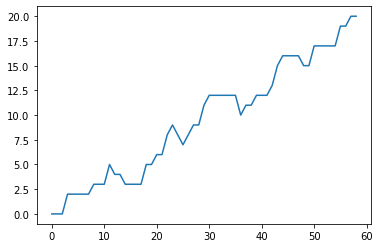

In [14]:
plt.plot(no_jobs_waiting)

plt.show()

In [15]:
process_time  = []
waiting_time = []
for job in job_queue:
    if job_queue[job]['status_flag'][0]:
        waiting_time.append(job_queue[job]['entry_time'][0] - job_queue[job]['arrival_time'][0])
        process_time.append(job_queue[job]['exit_time'][0] - job_queue[job]['entry_time'][0])

print("Mean Waiting Time: ", np.mean(waiting_time))
print("Mean Process Time: ", np.mean(process_time))
    

Mean Waiting Time:  13.728285344441732
Mean Process Time:  12.003920110066732


In [13]:
T_exp      = 60        # (in sec) Time for which the exp will run
rate       = 0.7         # job arrival rate
Nrun       = 30      
batch_size = 32
fct        = 10

job_queue[0] ={}
job_queue[0]['model_split']=[1,1]

#start1 = time.time()
#run_job(0, 'baseline', "ParallelThreeLayer", fct, batch_size, Nrun, [0], [0] )
#print("Done", time.time()-start1)
start2 = time.time()
run_job(0, 'baechi', "ParallelThreeLayer", fct, batch_size, Nrun, [0], [0] )
print("Done", time.time()-start2)


GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 2
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
Mean time taken: 63.786208629608154
Done 5.130145311355591


In [15]:
print_gpu_memory()

GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 3.51600647 GB
Cached:    3.51757812 GB
-----------
GPU: 2
Memory Usage:
Allocated: 0.97663879 GB
Cached:    0.97851562 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
